In [33]:
from plotnine import *
import pandas as pd

Reading in the final BART data after extensive data collection from various websites and data formatting in Excel

In [34]:
data = pd.read_excel("/Users/ethanschultz/Documents/GSB 544 Machine Learning/SMART Project/544_Final_Data.xlsx")
data.head()

,Month,Year,SF Gasoline Prices,Office space vacancy,Riders,Temp,Rain,Covid
0,1,2015,2.626,0.100,410847,55.4,0.00,0
1,2,2015,2.726,0.100,420906,59.4,1.47,0
2,3,2015,3.345,0.100,423526,60.0,0.12,0
3,4,2015,3.241,0.095,429910,57.0,1.30,0
4,5,2015,3.711,0.095,424312,55.7,0.00,0


First plot to see overall ridership levels since 2014, notice the huge drop off with a stead positive linear increase since COVID

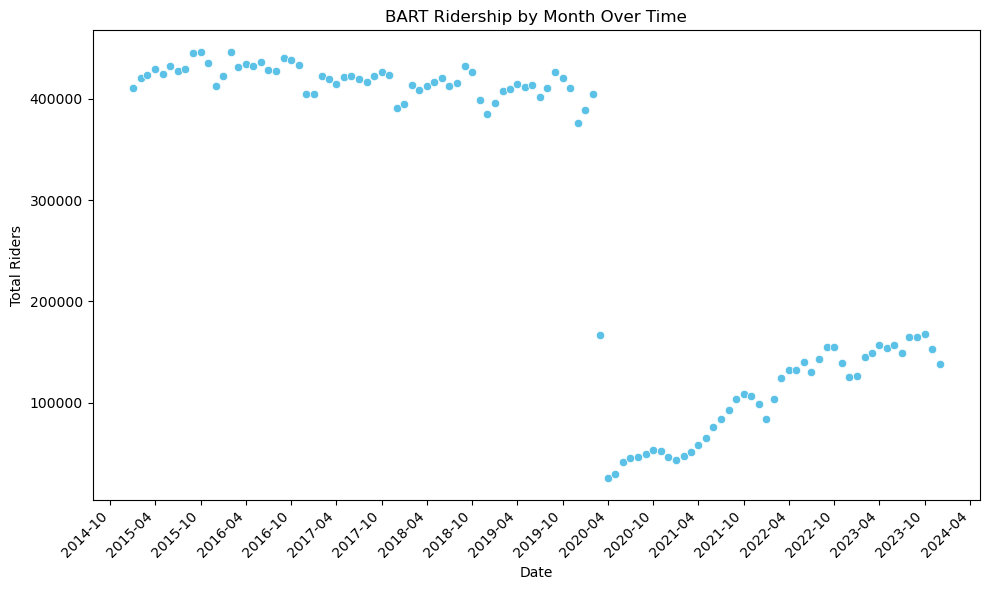

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# make a date column comining the month and year column in data
data['date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='date', y='Riders', color='#5bc1e6')

# Axis Formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=6))
plt.xticks(rotation=45, ha='right')

plt.xlabel("Date")
plt.ylabel("Total Riders")
plt.title("BART Ridership by Month Over Time")

# Show plot
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd

First modeling efforts begin with loading all packaged in that will be necessary

In [37]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

Train test split the data

In [41]:
X = data.drop(columns=['Month', 'Year', 'Riders','date'])
y = data['Riders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In this section, we will apply Ridge Regression to the dataset using a scit-learn
We'll use gridsearch for hyperparameter tuning, specifically searching for the best value of the regularization parameter in Ridge Regression 
After training the model, we'll extract the best model and evaluate it

In [61]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('ridge', Ridge())
])

ridge_params = {
    'ridge__alpha': np.logspace(-3, 3, 100)  # Regularization parameter
}

ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Best Ridge model
best_ridge = ridge_cv.best_estimator_
ridge_train_preds = best_ridge.predict(X_train)
ridge_test_preds = best_ridge.predict(X_test)

print("Ridge Regression Results:")
print(f"Best alpha: {ridge_cv.best_params_['ridge__alpha']}")

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_test_preds)):.4f}\n")

Ridge Regression Results:
Best alpha: 0.13219411484660287
Test RMSE: 11248.4253

Ridge Regression Results:
Best alpha: 0.13219411484660287
Test RMSE: 11248.4253



Next model was a lasso which we can see if it preformed better or worse than the first ridge model

In [65]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('lasso', Lasso(max_iter=10000))  # Ensure convergence
])

lasso_params = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]
}

lasso_cv = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)

# Best Lasso model
best_lasso = lasso_cv.best_estimator_
lasso_train_preds = best_lasso.predict(X_train)
lasso_test_preds = best_lasso.predict(X_test)

print("Lasso Regression Results:")
print(f"Best alpha: {lasso_cv.best_params_['lasso__alpha']}")

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, lasso_test_preds)):.4f}\n")

# Feature selection for Lasso
lasso_coef = best_lasso.named_steps['lasso'].coef_
print("Non-zero coefficients in Lasso:")
print(pd.Series(lasso_coef, index=X.columns)[lasso_coef != 0])

Lasso Regression Results:
Best alpha: 10.0
Test RMSE: 11161.0130

Non-zero coefficients in Lasso:
SF Gasoline Prices     -10072.955676
Office space vacancy     4863.209438
Temp                     5251.620357
Rain                     -769.046157
Covid                  -82580.196465
logriders               74977.896012
dtype: float64
Lasso Regression Results:
Best alpha: 10.0
Test RMSE: 11161.0130

Non-zero coefficients in Lasso:
SF Gasoline Prices     -10072.955676
Office space vacancy     4863.209438
Temp                     5251.620357
Rain                     -769.046157
Covid                  -82580.196465
logriders               74977.896012
dtype: float64


We can see the lasso model preformed slightly better than the ridge becasue of the slighty lower RSME. We can also see some of the coefficients the model produced and how each affect ridership levels. Key findings can be seen by corresponding positive or negative coefficients.

Also tried the same model but doing a log tranformation on ridership levels to see if it improved modeling

In [45]:
data_log = data
data_log['logriders'] = np.log(data['Riders'])

In [47]:
X = data_log.drop(columns=['Month', 'Year', 'Riders', 'logriders','date'])
y = data_log['logriders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('ridge', Ridge())
])

ridge_params = {
    'ridge__alpha': np.logspace(-3, 3, 100)  # Regularization parameter
}

ridge_cv = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Best Ridge model
best_ridge = ridge_cv.best_estimator_
ridge_train_preds = best_ridge.predict(X_train)
ridge_test_preds = best_ridge.predict(X_test)

print("Ridge Regression Results:")
print(f"Best alpha: {ridge_cv.best_params_['ridge__alpha']}")

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_test_preds)):.4f}\n")

Ridge Regression Results:
Best alpha: 0.13219411484660287
Train R2: 0.9970
Test R2: 0.9952
Test RMSE: 11248.4253

Ridge Regression Results:
Best alpha: 0.13219411484660287
Train R2: 0.9970
Test R2: 0.9952
Test RMSE: 11248.4253



The log transformaitn did not seem to improve the model much so for interprability purpases of coefficients the normal model will be prefered

If you remember from the initial graph their was clearly a severe drop in ridership levels so now we want to incorporate that and model off post and pre pandemic periods

In [67]:
pre_pandemic_data = data[data['Covid'] == 0]

post_pandemic_data = data[data['Covid'] == 1]

In [68]:
pre_pandemic_data.head()

,Month,Year,SF Gasoline Prices,Office space vacancy,Riders,Temp,Rain,Covid,date,logriders
0,1,2015,2.626,0.100,410847,55.4,0.00,0,2015-01-01,12.925976
1,2,2015,2.726,0.100,420906,59.4,1.47,0,2015-02-01,12.950165
2,3,2015,3.345,0.100,423526,60.0,0.12,0,2015-03-01,12.956370
3,4,2015,3.241,0.095,429910,57.0,1.30,0,2015-04-01,12.971331
4,5,2015,3.711,0.095,424312,55.7,0.00,0,2015-05-01,12.958224


In [22]:
from sklearn.linear_model import LinearRegression

In [51]:


# Define predictors and target
predictors = ['SF Gasoline Prices', 'Temp', 'Rain', 'Office space vacancy']
target = 'Riders'

# Split predictors and target for each dataset
X_pre = pre_pandemic_data[predictors]
y_pre = pre_pandemic_data[target]

X_post = post_pandemic_data[predictors]
y_post = post_pandemic_data[target]

# Define the pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('regressor', LinearRegression())  # Linear regression
])

# Train-test split for pre-pandemic data
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_pre, y_pre, test_size=0.2, random_state=42)

# Train-test split for post-pandemic data
X_train_post, X_test_post, y_train_post, y_test_post = train_test_split(X_post, y_post, test_size=0.2, random_state=42)

# Fit the model for pre-pandemic data
lr_pipeline.fit(X_train_pre, y_train_pre)
y_pred_pre = lr_pipeline.predict(X_test_pre)

# Metrics for pre-pandemic model
mse_pre = mean_squared_error(y_test_pre, y_pred_pre)
r2_pre = r2_score(y_test_pre, y_pred_pre)

print(f"Pre-Pandemic Model - MSE: {mse_pre:.2f}, R²: {r2_pre:.2f}")
coeffs_pre = lr_pipeline.named_steps['regressor'].coef_
intercept_pre = lr_pipeline.named_steps['regressor'].intercept_

print("\nPre-Pandemic Model Coefficients:")
for feature, coef in zip(predictors, coeffs_pre):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {intercept_pre:.4f}")
print('')

# Fit the model for post-pandemic data
lr_pipeline.fit(X_train_post, y_train_post)
y_pred_post = lr_pipeline.predict(X_test_post)

# Metrics for post-pandemic model
mse_post = mean_squared_error(y_test_post, y_pred_post)
r2_post = r2_score(y_test_post, y_pred_post)

print(f"Post-Pandemic Model - MSE: {mse_post:.2f}, R²: {r2_post:.2f}")


coeffs_post = lr_pipeline.named_steps['regressor'].coef_
intercept_post = lr_pipeline.named_steps['regressor'].intercept_

print("\nPost-Pandemic Model Coefficients:")
for feature, coef in zip(predictors, coeffs_post):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {intercept_post:.4f}")


Pre-Pandemic Model - MSE: 167094996.22, R²: 0.53

Pre-Pandemic Model Coefficients:
SF Gasoline Prices: -5873.8322
Temp: 6497.2524
Rain: -1289.4318
Office space vacancy: 2156.6379
Intercept: 419466.7347

Post-Pandemic Model - MSE: 372108729.96, R²: 0.85

Post-Pandemic Model Coefficients:
SF Gasoline Prices: 22457.2531
Temp: 1603.0276
Rain: 5126.8628
Office space vacancy: 13932.3972
Intercept: 105666.6667
Pre-Pandemic Model - MSE: 167094996.22, R²: 0.53

Pre-Pandemic Model Coefficients:
SF Gasoline Prices: -5873.8322
Temp: 6497.2524
Rain: -1289.4318
Office space vacancy: 2156.6379
Intercept: 419466.7347

Post-Pandemic Model - MSE: 372108729.96, R²: 0.85

Post-Pandemic Model Coefficients:
SF Gasoline Prices: 22457.2531
Temp: 1603.0276
Rain: 5126.8628
Office space vacancy: 13932.3972
Intercept: 105666.6667


We can see how each of the predicors affect ridership levels by splitting the data into pre and post pandemic to see if any of the coefficients increased or decreased or even changed signs to uncover how covid not only changed ridership but how these predictors changed based off it too. Note however this might not be very accurate as we see a bunch of significant changes likely due to the lack of a lot of data post pandemic and the steady increase in ridership levels just from people being more comfortable using public transportation again.

In [52]:
predictors = ['SF Gasoline Prices', 'Temp', 'Rain', 'Office space vacancy', 'Covid']
target = 'Riders'

# Split predictors and target
X = data[predictors]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('regressor', LinearRegression())  # Linear regression
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred = lr_pipeline.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coeffs = lr_pipeline.named_steps['regressor'].coef_
intercept = lr_pipeline.named_steps['regressor'].intercept_

# Print results
print(f"Full Dataset Model - MSE: {mse:.2f}, R²: {r2:.2f}\n")
print("Model Coefficients:")
for feature, coef in zip(predictors, coeffs):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {intercept:.4f}")

Full Dataset Model - MSE: 1350245011.85, R²: 0.95

Model Coefficients:
SF Gasoline Prices: 4257.2698
Temp: 9075.9190
Rain: 1714.5603
Office space vacancy: 47000.2773
Covid: -193692.3475
Intercept: 292231.0000
Full Dataset Model - MSE: 1350245011.85, R²: 0.95

Model Coefficients:
SF Gasoline Prices: 4257.2698
Temp: 9075.9190
Rain: 1714.5603
Office space vacancy: 47000.2773
Covid: -193692.3475
Intercept: 292231.0000


Now we combined the pre and post and just did a linear regression on the full model

In [53]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [54]:
predictors = ['SF Gasoline Prices', 'Temp', 'Rain', 'Office space vacancy', 'Covid']
target = 'Riders'

X = data[predictors]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define column transformer for polynomial features on Temp and Rain
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), ['Temp', 'Rain']),
        ('passthrough', 'passthrough', ['SF Gasoline Prices', 'Office space vacancy', 'Covid'])
    ]
)

# Define the pipeline
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('scaler', StandardScaler()),  
    ('regressor', LinearRegression())  
])

# Fit the model
poly_pipeline.fit(X_train, y_train)

y_pred = poly_pipeline.predict(X_test)

# Calculate metrics
mse2 = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Extract feature names from the preprocessor
feature_names = poly_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extract coefficients
coefficients = poly_pipeline.named_steps['regressor'].coef_
intercept = poly_pipeline.named_steps['regressor'].intercept_

# Output results
print(f"Polynomial Regression Model - MSE: {mse2:.2f}, R²: {r2:.2f}\n")
print("Model Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {intercept:.4f}")

Polynomial Regression Model - MSE: 1380503099.48, R²: 0.95

Model Coefficients:
poly__Temp: 46280.3416
poly__Rain: 42644.6092
poly__Temp^2: -35478.5605
poly__Temp Rain: -39584.8436
poly__Rain^2: 49.3984
passthrough__SF Gasoline Prices: 4330.7584
passthrough__Office space vacancy: 46998.8309
passthrough__Covid: -193456.2112
Intercept: 292231.0000
Polynomial Regression Model - MSE: 1380503099.48, R²: 0.95

Model Coefficients:
poly__Temp: 46280.3416
poly__Rain: 42644.6092
poly__Temp^2: -35478.5605
poly__Temp Rain: -39584.8436
poly__Rain^2: 49.3984
passthrough__SF Gasoline Prices: 4330.7584
passthrough__Office space vacancy: 46998.8309
passthrough__Covid: -193456.2112
Intercept: 292231.0000


Also tried different polynomical features of the predictors but RSME is slighly higher so this model also will not be considered becasue of this and increased difficulty in interpreting coefficients in polynomials

In [27]:
from sklearn.linear_model import ElasticNet

In [57]:
X = data.drop(columns=['Month', 'Year', 'Riders','date'])
y = data['Riders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:

# Define the pipeline with a scaler and ElasticNet
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('elastic', ElasticNet(random_state=42))  
])
# Hypertuning parameters
param_grid = {
    'elastic__alpha': [0.01, 0.1, 1.0, 10.0], 
    'elastic__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
    }

# Set up GridSearchCV
elastic_cv = GridSearchCV(
    estimator=elastic_pipeline,
    param_grid=param_grid,
    cv=5,  
    scoring='neg_mean_squared_error', 
    n_jobs=-1,  
    verbose=1 
)

# Perform grid search
elastic_cv.fit(X_train, y_train)

# Get the best model and predictions
best_elastic = elastic_cv.best_estimator_
elastic_train_preds = best_elastic.predict(X_train)
elastic_test_preds = best_elastic.predict(X_test)

# Evaluate the results
train_mse = mean_squared_error(y_train, elastic_train_preds)
test_mse = mean_squared_error(y_test, elastic_test_preds)

print("Best Parameters:", elastic_cv.best_params_)
print(f"Train Mean Squared Error: {train_mse:.2f}")
print(f"Test Mean Squared Error: {test_mse:.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.7}
Train Mean Squared Error: 73377942.69
Test Mean Squared Error: 131091840.29
Best Parameters: {'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.7}
Train Mean Squared Error: 73377942.69
Test Mean Squared Error: 131091840.29


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e+09, tolerance: 1.584e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+09, tolerance: 1.584e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.161e+08, toler

In [64]:
best_elastic = elastic_cv.best_estimator_

# Extract coefficients from the ElasticNet step
coefficients = best_elastic.named_steps['elastic'].coef_

# Predictions on train and test sets
elastic_train_preds = best_elastic.predict(X_train)
elastic_test_preds = best_elastic.predict(X_test)

# Evaluate the results
train_mse = mean_squared_error(y_train, elastic_train_preds)
test_mse = mean_squared_error(y_test, elastic_test_preds)

# Print results
print("Best Parameters:", elastic_cv.best_params_)
print(f"Train Mean Squared Error: {train_mse:.2f}")
print(f"Test Mean Squared Error: {test_mse:.2f}")

print("Coefficients:", coefficients)

Best Parameters: {'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.7}
Train Mean Squared Error: 73377942.69
Test Mean Squared Error: 131091840.29
Coefficients: [-11024.83488427   1172.37859504   5014.04761548   -862.47336431 -73845.11388014  80398.76265466]
Best Parameters: {'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.7}
Train Mean Squared Error: 73377942.69
Test Mean Squared Error: 131091840.29
Coefficients: [-11024.83488427   1172.37859504   5014.04761548   -862.47336431 -73845.11388014  80398.76265466]


Final model was elastic net which yielded the lowest RSME and will be considered for the final model at predicting ridership levels for BART and making key recommendations after interpreting model results